# **VAE Model**

### **i. Imports and subfunctions**

In [1]:
# Imports
import copy
import torch
import tqdm
import gc
import os
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from numba import cuda
from batchup import data_source
from torch.utils.data import Subset, DataLoader, random_split
from torchvision import transforms, datasets
from torchvision import transforms, datasets

def split_iid(dataset, n_centres):
    """ Split PyTorch dataset randomly into n_centres."""
    n_obs_per_center = [len(dataset) // n_centres for _ in range(n_centres)]
    return random_split(dataset, n_obs_per_center)

def split_per_subject(dataset, n_centres):
    pass

def federated_averaging(models, n_obs_per_client):
    """ Perform federated averaging."""
    # Error check inputs
    assert len(models) > 0
    assert len(n_obs_per_client) == len(models)

    # Compute proportions
    n_obs = sum(n_obs_per_client)
    proportions = [n_k / n_obs for n_k in n_obs_per_client]

    # Empty model parameter dictionary
    avg_params = models[0].state_dict()
    for key, val in avg_params.items():
        avg_params[key] = torch.zeros_like(val)

    # Compute average
    for model, proportion in zip(models, proportions):
        for key in avg_params.keys():
            avg_params[key] += proportion * model.state_dict()[key]

    # Copy one of the models and load trained params
    avg_model = copy.deepcopy(models[0])
    avg_model.load_state_dict(avg_params)

    return avg_model

def loss_plot(epochs, loss, axs=False):
    """ Plot loss curve."""
    if axs:
      axs.plot(epochs, loss)
    else:
      plt.plot(epochs, loss)



### **ii. General setup**

In [2]:
# Directories
basedir = '~/Projects/federated_autoencoder/'
datadir = os.path.join(basedir, 'data')

# Training hyperparameters
N_ROUNDS = 10
N_CENTRES = 4
N_EPOCHS = 50
N_FEATURES = 784
BATCH_SIZE = 128
HIDDEN_DIM = 400
LATENT_DIM = 200

# GPU settings
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
if device == 'cuda':
    gc.collect()
    torch.cuda.empty_cache()
    device = cuda.get_current_device()
    device.reset()

# # Load data
# mean = torch.Tensor([0.1307])
# std = torch.Tensor([0.3081])
# transform = transforms.Compose([transforms.ToTensor()])
# train_dataset = datasets.MNIST(root="~/torch_datasets", train=True,
#                                transform=transform, download=True)
# test_dataset = datasets.MNIST(root="~/torch_datasets", train=False,
#                               transform=transform, download=True)
# train_loader = torch.utils.data.DataLoader(train_dataset,
#                                            batch_size=BATCH_SIZE,
#                                            shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset,
#                                           batch_size=BATCH_SIZE,
#                                           shuffle=True)

# # Federate data
# federated_dataset = split_iid(train_dataset, n_centres=4)
# print('Number of centers:', len(federated_dataset))

# # Put data into dataloader
# for i, dataset in enumerate(federated_dataset):
#     federated_dataset[i] = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
#                                                        shuffle=True, num_workers=2, pin_memory=True)

# Load dataset
train_csv = os.path.join(datadir, 'train.csv')
train_df = pd.read_csv(train_csv)
label_dict = {'WALKING':0, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':2, 'SITTING':3, 'STANDING':4, 'LAYING':5}
train_X = train_df.values[:,:-2]
train_X = (train_X - train_X.mean()) / train_X.std()
train_y = train_df['Activity']
train_y = train_y.map(label_dict).values

# Construct an array data source
train_ds = data_source.ArrayDataSource([train_X, train_y])
train_batches = int(np.ceil(train_X.shape[0]/BATCH_SIZE))

In [4]:
train_X.shape

(7352, 561)

In [3]:
def read_data(path, filename):
    return pd.read_csv(os.path.join(path, filename), index_col=0)

df = read_data('./data/A_DeviceMotion_data/dws_1/', 'sub_1.csv')
df.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


In [4]:
def produce_magnitude(df, column):
    df[column+'.mag'] = np.sqrt(df[column+'.x']**2 + df[column+'.y']**2 + df[column+'.z']**2)

produce_magnitude(df, 'userAcceleration')
produce_magnitude(df, 'rotationRate')
df.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,userAcceleration.mag,rotationRate.mag
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,0.513360,1.370498
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,0.250235,1.141648
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,0.215450,0.372530
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,0.166728,1.049628
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,0.408720,0.921229


In [5]:
import numpy as np
import pandas as pd

def get_ds_infos():
    """
    Read the file includes data subject information.
    
    Data Columns:
    0: code [1-24]
    1: weight [kg]
    2: height [cm]
    3: age [years]
    4: gender [0:Female, 1:Male]
    
    Returns:
        A pandas DataFrame that contains inforamtion about data subjects' attributes 
    """ 

    dss = pd.read_csv("./data/data_subjects_info.csv")
    print("[INFO] -- Data subjects' information is imported.")
    
    return dss

def set_data_types(data_types=["userAcceleration"]):
    """
    Select the sensors and the mode to shape the final dataset.
    
    Args:
        data_types: A list of sensor data type from this list: [attitude, gravity, rotationRate, userAcceleration] 

    Returns:
        It returns a list of columns to use for creating time-series from files.
    """
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])
    print(dt_list)
    return dt_list


def creat_time_series(folder_name, dt_list, act_labels, trial_codes, mode="mag", labeled=True):
    """
    Args:
        folder_name: one of 'A_DeviceMotion_data', 'B_Accelerometer_data', or C_Gyroscope_data
        dt_list: A list of columns that shows the type of data we want.
        act_labels: list of activites
        trial_codes: list of trials
        mode: It can be 'raw' which means you want raw data
        for every dimention of each data type,
        [attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)].
        or it can be 'mag' which means you only want the magnitude for each data type: (x^2+y^2+z^2)^(1/2)
        labeled: True, if we want a labeld dataset. False, if we only want sensor values.

    Returns:
        It returns a time-series of sensor data.
    
    """
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list*3)

    if labeled:
        dataset = np.zeros((0,num_data_cols+7)) # "7" --> [act, code, weight, height, age, gender, trial] 
    else:
        dataset = np.zeros((0,num_data_cols))
        
    ds_list = get_ds_infos()
    
    print("[INFO] -- Creating Time-Series")
    for sub_id in ds_list["code"]:
        for act_id, act in enumerate(act_labels):
            for trial in trial_codes[act_id]:
                fname = folder_name+'/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:,x_id] = (raw_data[axes]**2).sum(axis=1)**0.5        
                    else:
                        vals[:,x_id*3:(x_id+1)*3] = raw_data[axes].values
                    vals = vals[:,:num_data_cols]
                if labeled:
                    lbls = np.array([[act_id,
                            sub_id-1,
                            ds_list["weight"][sub_id-1],
                            ds_list["height"][sub_id-1],
                            ds_list["age"][sub_id-1],
                            ds_list["gender"][sub_id-1],
                            trial          
                           ]]*len(raw_data), dtype=int)
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset,vals, axis=0)
    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]
            
    if labeled:
        cols += ["act", "id", "weight", "height", "age", "gender", "trial"]
    
    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset
#________________________________

In [6]:
sdt = ["rotationRate", "userAcceleration"]
print("Selected sensor data types:\n" + str(sdt))
dt_list = set_data_types(sdt)
print("\nSelected columns from dataset:\n" + str(dt_list))

Selected sensor data types:
['rotationRate', 'userAcceleration']
[['rotationRate.x', 'rotationRate.y', 'rotationRate.z'], ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']]

Selected columns from dataset:
[['rotationRate.x', 'rotationRate.y', 'rotationRate.z'], ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']]


In [7]:
ACT_LABELS = ["sit", "std", "dws", "ups", "wlk", "jog"]
act_labels = ACT_LABELS [0:6]  # all activities
print("Selected activites: " + str(act_labels)) 

Selected activites: ['sit', 'std', 'dws', 'ups', 'wlk', 'jog']


In [8]:
TRIAL_CODES = {
    ACT_LABELS[0]:[5],
    ACT_LABELS[1]:[6],
    ACT_LABELS[2]:[1],
    ACT_LABELS[3]:[3],
    ACT_LABELS[4]:[7],
    ACT_LABELS[5]:[9],
}
trial_codes = [TRIAL_CODES[act] for act in act_labels]
print("[INFO] -- Selected trials: " + str(trial_codes))

[INFO] -- Selected trials: [[5], [6], [1], [3], [7], [9]]


In [9]:
print("Loading...")
dataset = creat_time_series("./data/A_DeviceMotion_data", dt_list, act_labels, trial_codes, mode="mag", labeled=True)
print("Finished!")
dataset

Loading...
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
Finished!


,rotationRate,userAcceleration,act,id,weight,height,age,gender,trial
0,0.010253,0.006959,0.0,0.0,102.0,188.0,46.0,1.0,5.0
1,0.010920,0.010673,0.0,0.0,102.0,188.0,46.0,1.0,5.0
2,0.008377,0.007010,0.0,0.0,102.0,188.0,46.0,1.0,5.0
3,0.006555,0.014892,0.0,0.0,102.0,188.0,46.0,1.0,5.0
4,0.007724,0.013001,0.0,0.0,102.0,188.0,46.0,1.0,5.0
...,...,...,...,...,...,...,...,...,...
830890,6.944461,1.490388,5.0,23.0,74.0,173.0,18.0,0.0,9.0
830891,7.327530,5.192210,5.0,23.0,74.0,173.0,18.0,0.0,9.0
830892,7.364810,4.236564,5.0,23.0,74.0,173.0,18.0,0.0,9.0
830893,6.051690,1.504475,5.0,23.0,74.0,173.0,18.0,0.0,9.0


In [10]:
period = 2.5 # Seconds
sample_rate = 50 # Hz
points = int(period*sample_rate)
points

125

In [13]:
data_list = []
labels = []

act_data = np.zeros((6,points))
for uid in range(1):
    for act in np.unique(dataset["act"]):
        act =int(act)
        data = dataset[(dataset["id"] == uid) & (dataset["act"] == act)]
        acc = data["userAcceleration"].values
        rot = data["rotationRate"].values
        for i in range(0, len(data), points):
            feature_series = np.vstack((acc[i:i+125], rot[i:i+125])).T
            time_steps = feature_series.shape[0]
            if time_steps != points:
                to_pad = points - time_steps
                if to_pad % 2 == 0:
                    pad_tuple = (int(to_pad/2), int(to_pad/2))
                else:
                    pad_tuple = (int(np.ceil(to_pad/2)),int(np.floor(to_pad/2)))
                feature_series = np.pad(feature_series, (pad_tuple,(0,0)), 'constant')
            data_list.append(feature_series)
            labels.append(act)
total_data = np.stack(data_list)

## **1. Create models**

In [39]:
nn.Conv1d(125, 200, 3, 2, 1)

Conv1d(125, 200, kernel_size=(3,), stride=(2,), padding=(1,))

In [103]:
class VAE(nn.Module):
    def __init__(self,
                 seq_len=125,
                 feat_dim=2,
                 latent_dim=2,
                 hidden_layer_sizes=[100, 200]):
        super(VAE, self).__init__()

        # Assign variables
        self.seq_len = seq_len
        self.feat_dim = feat_dim
        self.latent_dim = latent_dim
        self.hidden_layer_sizes = hidden_layer_sizes

        # Build Encoder
        modules = []
        modules.append(
            nn.Sequential(
                nn.Conv1d(self.seq_len, self.hidden_layer_sizes[0], kernel_size=3, stride=2, padding=1),
                nn.ReLU(),
                nn.Conv1d(self.hidden_layer_sizes[0], self.hidden_layer_sizes[1], kernel_size=3, stride=2, padding=1),
                nn.ReLU(),
                )
        )

        # Build encoder
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(self.hidden_layer_sizes[1], self.latent_dim)
        self.fc_var = nn.Linear(self.hidden_layer_sizes[1], self.latent_dim)

        # Build decoder
        modules = []
        modules.append(
            nn.Sequential(
                nn.Linear(self.latent_dim, 1),
                nn.ReLU(),
                nn.ConvTranspose1d(self.seq_len, self.hidden_layer_sizes[1], kernel_size=3, stride=2, padding=1),
                nn.ReLU(),
                nn.ConvTranspose1d(self.seq_len, self.hidden_layer_sizes[0], kernel_size=3, stride=2, padding=1),
                nn.ReLU(),
                nn.ConvTranspose1d(self.seq_len, self.feat_dim, kernel_size=3, stride=2, padding=1),
                nn.ReLU(),
                nn.Flatten(),
                )
        )
        self.decoder = nn.Sequential(*modules) 
      
    def encode(self, x):
        """ Encode input to mean and logvar."""
        # Get values from encoding features
        test = nn.Conv1d(self.seq_len, self.hidden_layer_sizes[0], kernel_size=3, stride=2, padding=1).forward(x)
        print(test.shape)
        test = nn.ReLU().forward(test)
        print(test.shape)
        test = nn.Conv1d(self.hidden_layer_sizes[0], self.hidden_layer_sizes[1], kernel_size=3, stride=2, padding=1).forward(test)
        print(test.shape)
        test = nn.ReLU().forward(test)
        print(test.shape)

        result = self.encoder(x)
        print(result.shape)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        print('aaaaa')
        mu = self.fc_mu(result)
        print('okokokok')
        logvar = self.fc_var(result)
        print('feqwfewqf')
        return [mu, logvar]
    
    def reparameterise(self, mu, logvar):
        """ Reparameterise to sample."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def decode(self, z):
        """ Decode latent sampling to output."""
        result = self.decoder(z)
        return result

    def forward(self, x):
        """ Forward pass of the network."""
        # Check input length matches in_features
        # if x.shape[-1] != self.in_features:
        #     raise Exception(f'Input features must be equal to {self.in_features}!')

        # Encode input to mean and logvar
        mu, logvar = self.encode(x)

        print('ojgreqwr')

        # Reparameterise
        z = self.reparameterise(mu, logvar)

        print('agogogo')

        # Decode and return values
        return [self.decode(z), x, mu, logvar]
    
class VAELoss(nn.Module):
    def __init__(self):
        super(VAELoss, self).__init__()
        self.criterion = F.mse_loss

    def forward(self, outputs, inputs, mu, logvar, Beta=5):   
        recon_loss = self.criterion(outputs, inputs, reduction='sum')
        kl = 0.5 * torch.sum(-1 - logvar + mu.pow(2) + logvar.exp())
        return recon_loss, kl, recon_loss + kl

## **2. Train VAE**

In [104]:
# Initialise model
StandardVAE = VAE().to(device)
params = sum(p.numel() for p in StandardVAE.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(StandardVAE)

# Optimiser and loss
optimizer = torch.optim.Adam(StandardVAE.parameters(), lr=1e-3)
criterion = VAELoss()

Total number of parameters is: 175259
VAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv1d(2, 100, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): ReLU()
      (2): Conv1d(100, 200, kernel_size=(3,), stride=(2,), padding=(1,))
      (3): ReLU()
    )
  )
  (fc_mu): Linear(in_features=200, out_features=2, bias=True)
  (fc_var): Linear(in_features=200, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=1, bias=True)
      (1): ReLU()
      (2): ConvTranspose1d(125, 200, kernel_size=(3,), stride=(2,), padding=(1,))
      (3): ReLU()
      (4): ConvTranspose1d(125, 100, kernel_size=(3,), stride=(2,), padding=(1,))
      (5): ReLU()
      (6): ConvTranspose1d(125, 2, kernel_size=(3,), stride=(2,), padding=(1,))
      (7): ReLU()
      (8): Flatten(start_dim=1, end_dim=-1)
    )
  )
)


In [105]:
# Initialise model
StandardVAE.train()
losses = {'recon': [],
          'kl': [],
          'training': []
          }
print('Beginning standard VAE training...\n')
for epoch in range(1):
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    running_train_loss = 0.0
    # with tqdm.tqdm(train_ds.batch_iterator(batch_size=BATCH_SIZE,
    #                                        shuffle=np.random.RandomState(12345)),
    #                unit='batch', total=train_batches) as tepoch:
    #     for batch_idx, (batch_X, batch_y) in enumerate(tepoch):
    for batch in total_data:
        # Batch tensor
        batch_tensor = torch.Tensor(batch.astype(np.float64)).to(device)

        # Compute reconstructions
        results, x, mu, logvar = StandardVAE(batch_tensor)

        # Loss
        recon_loss, kl_loss, train_loss = criterion(results, batch_tensor,
                                                    mu=mu, logvar=logvar)

        # Backpropagation based on the loss
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Update loss
        running_recon_loss += recon_loss.item()
        running_kl_loss += kl_loss.item()
        running_train_loss += train_loss.item()

        # Log
        if batch_idx % 20 == 0:
            tepoch.set_description(f"Epoch {epoch+1}")
            tepoch.set_postfix(loss=train_loss.item())

    # Average epoch loss
    losses['recon'].append(running_recon_loss/batch_idx+1)
    losses['kl'].append(running_kl_loss/batch_idx+1)
    losses['training'].append(running_train_loss/batch_idx+1)

Beginning standard VAE training...



RuntimeError: Given groups=1, weight of size [100, 2, 3], expected input[1, 125, 2] to have 2 channels, but got 125 channels instead

## **2.1 Loss curves**

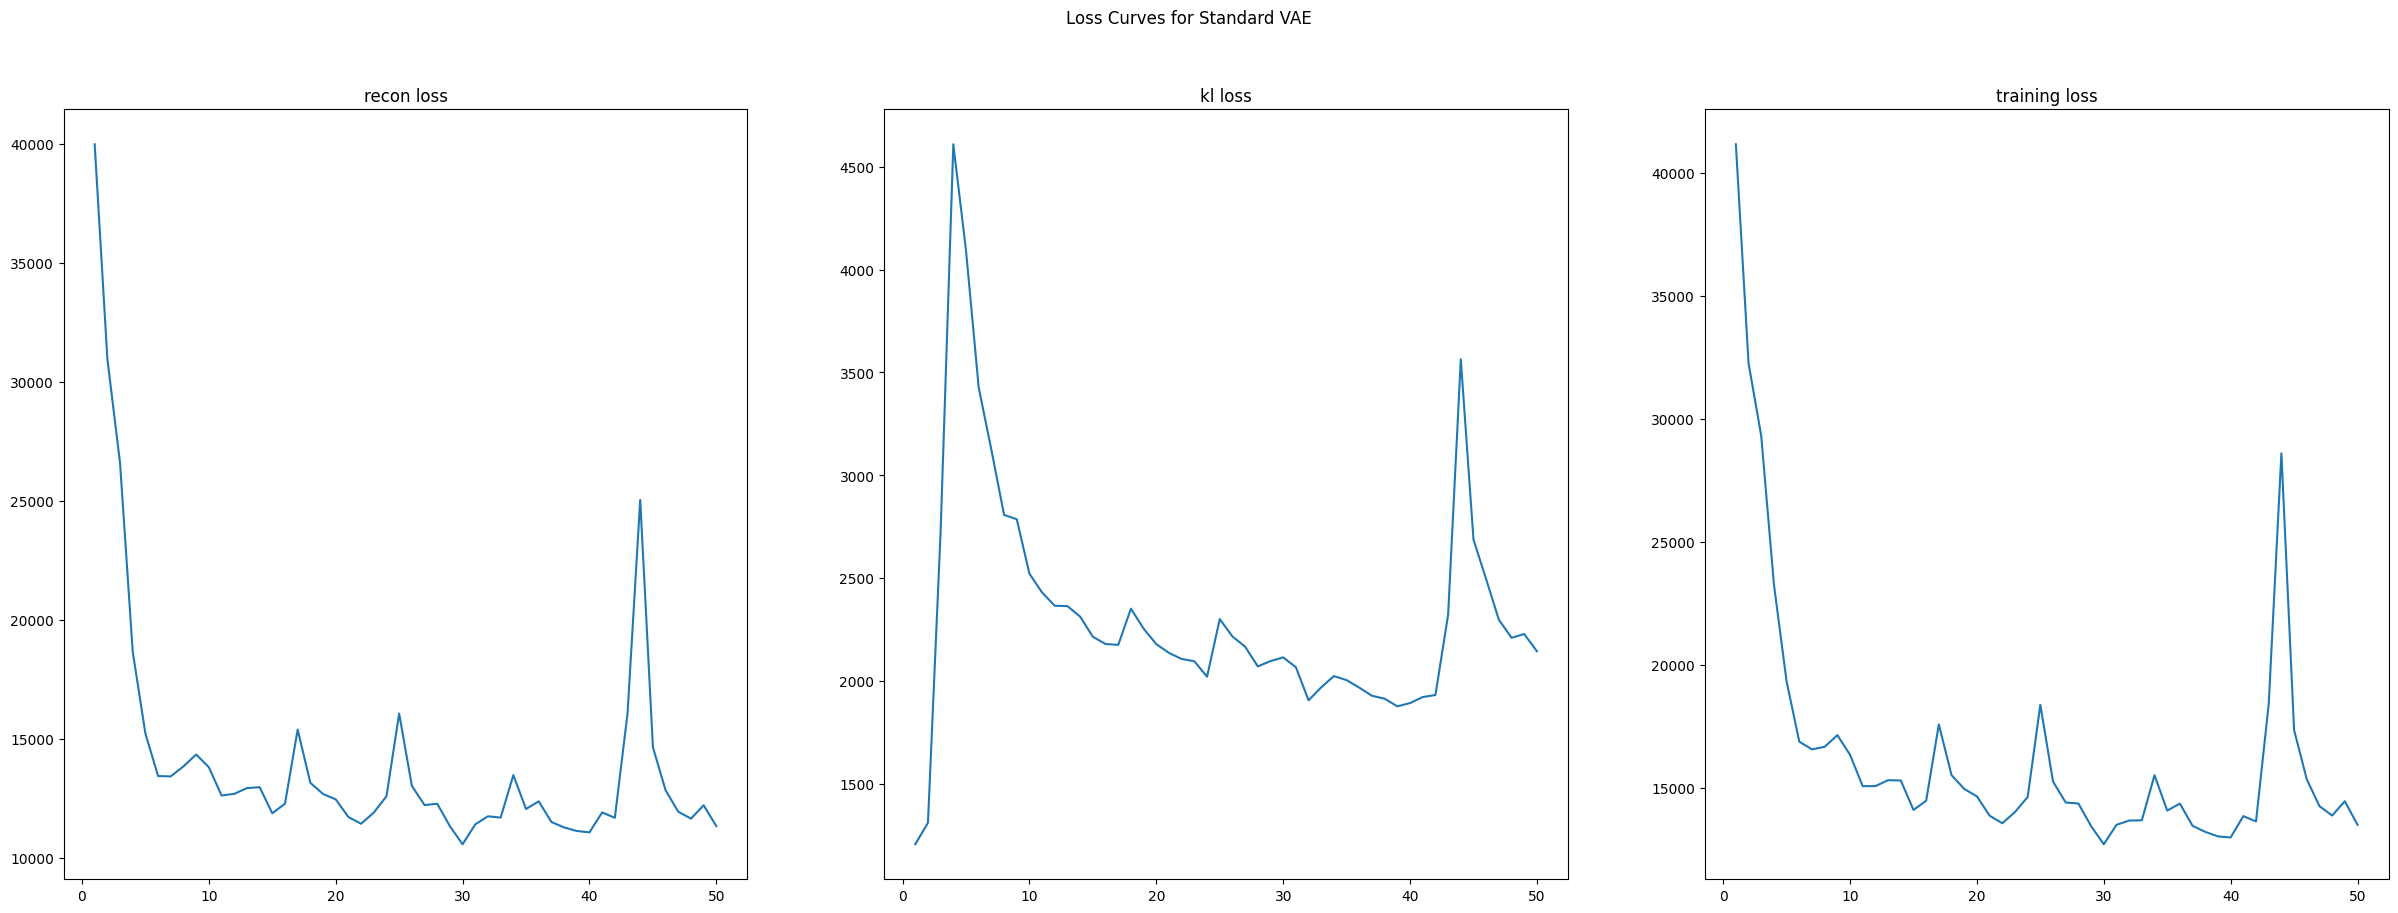

In [6]:
# Loss plots
fig, axs = plt.subplots(1,3, figsize=(30,10))
plt.suptitle("Loss Curves for Standard VAE")
for i, k in enumerate(losses):
  loss_plot(np.linspace(1, N_EPOCHS, N_EPOCHS).astype(int), losses[k], axs=axs[i])
  axs[i].set_title(f"{k} loss")


## **3. Analyse VAE**

Input images
--------------------------------------------------


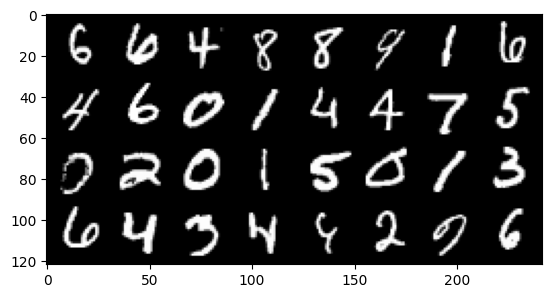

Reconstructed images
--------------------------------------------------


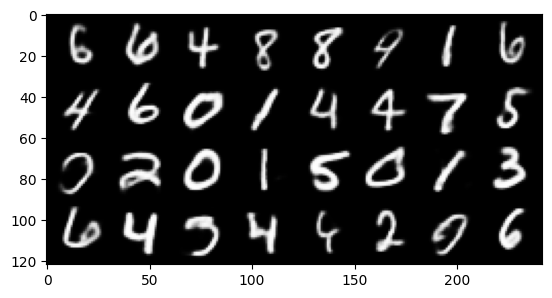

Generated Images
--------------------------------------------------


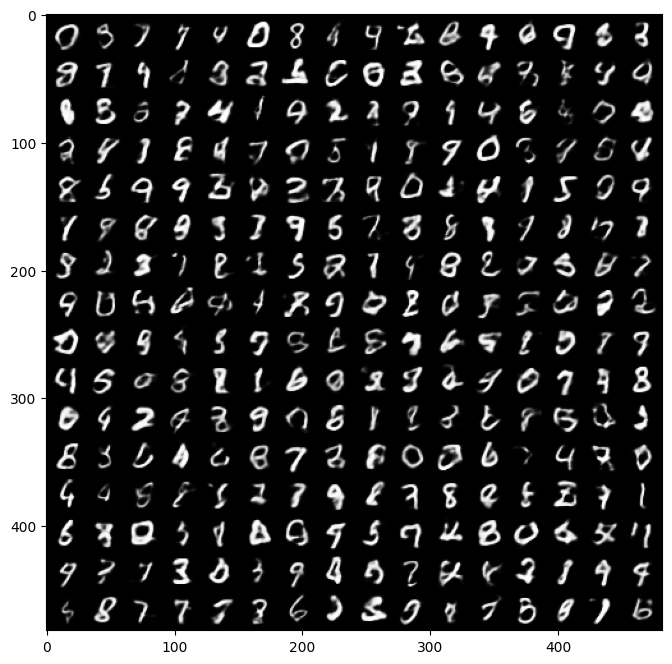

In [8]:
# Visualise original images
print('Input images')
print('-'*50)
sample_inputs, _ = next(iter(test_loader))
fixed_input = sample_inputs[0:32, :, :, :]
img = make_grid(fixed_input, nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
show(img)
plt.show()


print('Reconstructed images')
print('-'*50)
StandardVAE.eval()
with torch.no_grad():
    # Visualize the reconstructed images of the last batch of test set
    fixed_input = fixed_input.to(device)
    recon_batch = StandardVAE(fixed_input)
    recon_batch = recon_batch[0].cpu()
    recon_batch = recon_batch.view(recon_batch.shape[0], 1, 28, 28)
    recon_batch = make_grid(recon_batch, nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    show(recon_batch)
    plt.show()

print('Generated Images')  
print('-'*50)
StandardVAE.eval()
n_samples = 256
z = torch.randn(n_samples, LATENT_DIM).to(device)
with torch.no_grad():
    samples = StandardVAE.decode(z)
    samples = samples.view(n_samples, 1, 28, 28)
    samples = samples.cpu()
    samples = make_grid(samples, nrow=16, padding=2, normalize=False,
                        range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)

